### Solutions of PS2

This notebook is in html. To be able to run it, please click: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gunerilhan/economicgrowth/blob/master/ps2/ps2.ipynb)

In [1]:
# First import the packages we'll need
# Numpy is for numerical analysis
import numpy as np
# Pandas is for data storage and manipulation
import pandas as pd
# Matplotlib and seaborn are for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style
style.use('https://gunerilhan.github.io/img/fivethirtyeight-modified.mplstyle')

In [2]:
# Different color palettes that can be used in plots
colors = {0:['#264653','#219D8F','#E9C46A','#F4A261','#E76F51'],
  1:['#003049','#D62828','#F77F00','#FCBF49','#EAE2B7'],
  2:['#F72585','#7209B7','#3A0CA3','#4361EE','#4CC9F0'],
  3: ['#165aa7','#cb495c','#bb60d5','#f47915','#06ab54','#002070','#b27d12','#007030']}




1. Go to the following website: https://www.rug.nl/ggdc/productivity/pwt/

Download Penn World Table version 10.0 database in your preferred format. Consider the following countries: the UK, Argentina, Denmark, Central African Republic, Nigeria and Italy.

a.  Using data in 2019, calculate real output per worker and human capital index for each of the countries listed above. Use 
 - 'cgdpe' (Expenditure-side real GDP at current PPPs (in mil. 2017US$)) as a measure of real GDP,
 - 'emp' (Number of persons engaged (in millions)) as a measure of employment, 
 - and 'hc' (Human capital index, based on years of schooling and returns to education) as a measure of human capital.

b.  Assume a Cobb-Douglas production function with $\alpha=1/3$. Suppose countries differ only with respect to their investment rates. For each country listed above, calculate Solow model's predicted output per worker relative to the UK output per worker. For investment rates of countries, use average of variable `csh\_i' (Share of gross capital formation at current PPPs) over the years 1970-2019. Generate a table comparing Solow model's predicted output per worker relative to the UK with actual output per worker relative to the UK (in 2019, or in the latest available year). Hint, I ask you to do an exercise similar to what we have done in lecture 3. Briefly comment on the table. 

c. Now, assume that countries differ with respect to their investment rates and employment growth rates. Assume that depreciation rates in all countries are equal to 5%, $\delta=0.05$. Calculate average annual employment growth rates of the above listed countries from 1970 to 2019. Repeat the exercise in part b. Create a table that compares Solow model's predicted output per worker differences with actual output per worker differences relative to the UK. Briefly comment on the table.

d. Now, assume that countries differ not only in their investment and employment growth rates but also in their human capital. For this exercise use variable hc in 2019 (Human capital index, based on years of schooling and returns to education) as $h$ in the Solow model. Assume that depreciation rates in all countries are equal to 5%, $\delta=0.05$. Repeat part c while considering human capital differences across countries. Create a table and briefly comment on it.

e.Do your predictions approach to actual income differences as you take into account more variables? 



In [3]:
# Here, I download the Penn World Tables legend
df_legend = pd.read_excel('https://www.rug.nl/ggdc/docs/pwt100.xlsx',sheet_name='Legend')
df_legend.dropna(subset=['Variable name','Variable definition'],inplace=True)
# I create a dictionary of variables names and definitions
df_legend = dict(zip(df_legend['Variable name'],df_legend['Variable definition']))

In [4]:
# Here are the variables, we will need in this analysis
print('cgdpe = ', df_legend['cgdpe'])
print('rnna = ', df_legend['rnna'])
print('emp = ', df_legend['emp'])
print('hc =', df_legend['hc'])
print('csh_i =', df_legend['csh_i'])

cgdpe =  Expenditure-side real GDP at current PPPs (in mil. 2017US$)
rnna =  Capital stock at constant 2017 national prices (in mil. 2017US$)
emp =  Number of persons engaged (in millions)
hc = Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.
csh_i = Share of gross capital formation at current PPPs


In [5]:
# now download the data
df = pd.read_excel('https://www.rug.nl/ggdc/docs/pwt100.xlsx',sheet_name='Data')

In [6]:
# create GDP per worker 
df['gdpPerworker'] = df['cgdpe']/df.emp

In [7]:
# Penn World Tables contain many variables, but these are the variables ...
# I need to create the table asked in part a
var_list = ['countrycode','country','cgdpe','emp','hc','year']

In [8]:
# List of countries
country_list = ['GBR','ARG','DNK','CAF','NGA','ITA']

In [9]:
## Here, we create the table asked in part a)

# This cell does five things:
# 1) It selects the countries in my list: df.countrycode.isin(country_list)
# 2) It selects year 2017: (df.year==201-)
# 3) It selects the variables that I want to display :
#               [['country','year','gdpPerworker','hc','emp','pop']]
# 4) It rounds the variables to 2 decimal points: .round(decimals=2)
# 5) Sets country as index: .set_index('country') 
df[df.countrycode.isin(country_list) & (df.year==2019)][
    ['country','year','gdpPerworker','hc','emp','pop']].round(decimals=2)

,country,year,gdpPerworker,hc,emp,pop
419,Argentina,2019,48028.63,3.10,20.64,44.78
2099,Central African Republic,2019,2452.78,1.56,1.84,4.75
3499,Denmark,2019,108220.47,3.60,2.97,5.77
4339,United Kingdom,2019,94307.44,3.77,32.98,67.53
5949,Italy,2019,97679.75,3.16,25.60,60.55
8749,Nigeria,2019,13446.26,1.97,73.02,200.96


In [10]:
## To solve part b, I first need to calculate average investment rate ...
# for each country from 1970 to 2009

# This cell does the following things:
# 1) It selects data from years 1970 to 2019: df[df.year.isin(np.arange(1970,2020))]
# np.arange(1970,2020) creates a list from 1970 to 2019.
# intervals on python is right-open. Hence np.arange(1970,2020) creates 
# an array that does not inclue 2020
# 2) it takes averages of the investment rates for each country:
                #.groupby(['countrycode','country'])['csh_i'].mean()
# 3) it resets data index
# 4) it renames 'csh_i' variable to "Investment rate"
    
begin,end=1970,2019
df_fundamentals = (df[df.year.isin(np.arange(begin,end+1))]
                   .groupby(['countrycode','country'])['csh_i'].mean().reset_index().rename(
                       columns={'csh_i':'Investment rate'}))

In [11]:
# Now look at he investment rate of the countries we calculated above
# In fact we calculated invesment rate for each country in our data
# we display investment rate only for the countries we are interested in

df_fundamentals.set_index('countrycode',inplace=True)
df_fundamentals.loc[country_list].round(decimals=2)

,country,Investment rate
countrycode,,
GBR,United Kingdom,0.23
ARG,Argentina,0.15
DNK,Denmark,0.26
CAF,Central African Republic,0.14
NGA,Nigeria,0.38
ITA,Italy,0.26


In [12]:
# In part c, we need to calculate the average employment growth

In [13]:
# first sort our data by country and by year
# we need by year sorting to ensure that 1970 data comes earlier than 2017 data ...
# in our dataset. We need this in the next cell
df.sort_values(['countrycode','year'],inplace=True)

In [14]:
# This cell calculates the average annual employment growth rate from 1970 to 2017
# It first selects the years 1970 and 2019
# For each country it calculate average annual employment growth rate ...
# using this formula = (emp_2019/emp_1970)^(1/49)-1
# there are multiple ways of calculating average employment growth rate,...
# the above is one of them

# Here is how code works:
# 1) it selects data from years 1970 and 2019: df[df.year.isin([1970,2019])]
# 2) It groups the data based on countrycodes: .groupby(['countrycode']
# 3) for each country code, we have 2 observations, from 1970 and from 2019
# x['emp'].values[0] is the first observation from 1970 
# x['emp'].values[1] is the second observation from 2019
# the average annual employment growth is equal to 
# x['emp'].values[1]/x['emp'].values[0])**(1/49)-1, ...
# where x represent a country
# 4) Lastly it renames what we calculated as 
# 'Employment growth': .rename(columns={0:'Employment growth'})

df_emp_growth = (df[df.year.isin([begin,end])]
                 .groupby(['countrycode']).apply(lambda x: 
                (x['emp'].values[1]/x['emp'].values[0])**(1/(end-begin))-1)
                 .reset_index().rename(columns={0:'Employment growth'}))

In [15]:
# show the employment growth rate for the countries we selected
df_emp_growth.set_index('countrycode',inplace=True)
df_emp_growth.loc[country_list].round(decimals=3)

,Employment growth
countrycode,
GBR,0.006
ARG,0.018
DNK,0.004
CAF,NaN
NGA,0.025
ITA,0.005


Above, since data for CAF is missing in 1970, our method did not give a result for CAF. 
Alternatively, we could calculate employment growth for each available year, and take average of the 
employment growth rates.

In [16]:
# merge df_fundamentals data (contains invesment rates) 
# with df_emp_growth (contains employment growth rate)
df_fundamentals= df_fundamentals.join(df_emp_growth,how='left')

In [17]:
# in part d, we will need human capital values
# merge our df_fundamentals data with the Penn World Tables
# but, we don't need all of PWT, select only year 2019, and other required variables
df_fundamentals = df_fundamentals.join(df[df.year == end].set_index('countrycode')[
    ['emp','gdpPerworker','hc']],how='left')

In [18]:
# we will calculate Solow's predicted output per worker relative to the UK
# hence, create a different data just for the UK values
gbr = df_fundamentals.loc['GBR']

In [19]:
# now add columns to df_fundamentals data, consisting of corresponding values from the UK
for var in ['Investment rate','Employment growth','hc','gdpPerworker']:
    df_fundamentals[f'{var}, GBR'] = gbr[var]

In [20]:
# here is our data
df_fundamentals.loc[country_list].round(decimals=3)

,country,Investment rate,Employment growth,emp,gdpPerworker,hc,"Investment rate, GBR","Employment growth, GBR","hc, GBR","gdpPerworker, GBR"
countrycode,,,,,,,,,,
GBR,United Kingdom,0.232,0.006,32.982,94307.441,3.774,0.232,0.006,3.774,94307.441
ARG,Argentina,0.151,0.018,20.643,48028.635,3.097,0.232,0.006,3.774,94307.441
DNK,Denmark,0.265,0.004,2.972,108220.474,3.599,0.232,0.006,3.774,94307.441
CAF,Central African Republic,0.138,NaN,1.844,2452.784,1.562,0.232,0.006,3.774,94307.441
NGA,Nigeria,0.382,0.025,73.021,13446.265,1.974,0.232,0.006,3.774,94307.441
ITA,Italy,0.263,0.005,25.596,97679.750,3.158,0.232,0.006,3.774,94307.441


In [21]:
# We have prepared our data to conduct the required analysis
# First set our parameter values
alpha=1/3
delta = 0.05
# In many parts of the analysis, we will write alpha/(1-alpha)...
# create a new variable to redue typing
alpham = alpha/(1-alpha)

Notice that at the steady state of the Solow model income per worker is equal to
$$y^\ast = A^{1/(1-\alpha)}\left(\frac{\gamma}{\delta+n} \right)^{\alpha/(1-\alpha)}h.$$

Therefore income per worker ratios are (assuming countries have the same technology, $A$):
$$\frac{y_i}{y_{UK}} = \left(\frac{\frac{\gamma_i}{\delta+n_i}}{\frac{\gamma_{UK}}{\delta+n_{UK}}} \right)^{\alpha/(1-\alpha)}\frac{h_i}{h_{UK}}.$$

Rewrite the above formula:
$$\frac{y_i}{y_{UK}} = \left(\frac{\gamma_i}{\gamma_{UK}}\right)^{\alpha/(1-\alpha)}\left(\frac{\delta+n_{UK}}{\delta+n_i}\right)^{\alpha/(1-\alpha)}\frac{h_i}{h_{UK}}.$$




In part b, we assume countries differ only with respect to their investment rates. Therefore:
$$\frac{y_i}{y_{UK}} = \left(\frac{\gamma_i}{\gamma_{UK}}\right)^{\alpha/(1-\alpha)}.$$

    


In [22]:
# calculate Solow's predicted income per worker ratios as in the above formula
df_fundamentals['rel_GDP_pred_inv']=(df_fundamentals['Investment rate']
                                     /df_fundamentals['Investment rate, GBR'])**alpham

In [23]:
# calculate the actual output per worker rations from data
df_fundamentals['rel_GDP'] = (df_fundamentals['gdpPerworker']/
                              df_fundamentals['gdpPerworker, GBR'])

In part c, countries differ with respect to their employment growth rates as well as their investment rates:

$$\frac{y_i}{y_{UK}} = \left(\frac{\frac{\gamma_i}{\delta+n_i}}{\frac{\gamma_{UK}}{\delta+n_{UK}}} \right)^{\alpha/(1-\alpha)}.$$




In [24]:
## calculate Solow's predicted income per worker ratios as in the above formula
df_fundamentals['rel_GDP_pred_inv_emp']=((df_fundamentals['Investment rate']/
                                          (delta+df_fundamentals['Employment growth']))
                                         /(df_fundamentals['Investment rate, GBR']/
                            (delta+df_fundamentals['Employment growth, GBR'])))**alpham

In part d, countries differ with respect to their human capital, employment growth rate and investment rate



$$\frac{y_i}{y_{UK}} = \left(\frac{\frac{\gamma_i}{\delta+n_i}}{\frac{\gamma_{UK}}{\delta+n_{UK}}} \right)^{\alpha/(1-\alpha)}\frac{h_i}{h_{UK}}.$$



In [25]:
## calculate Solow's predicted income per worker ratios as in the above formula
df_fundamentals['rel_GDP_pred_inv_emp_hc'] = (df_fundamentals['rel_GDP_pred_inv_emp']*
                                    df_fundamentals['hc']/df_fundamentals['hc, GBR'])

In [26]:
# I need this cell to rename the table columns
column_names = dict(zip(['rel_GDP_pred_inv','rel_GDP_pred_inv_emp','rel_GDP_pred_inv_emp_hc','rel_GDP'],
    ['Prediction, part b','Prediction, part c','Prediction, part d','Actual']))

In [27]:
df_fundamentals.loc[country_list]

,country,Investment rate,Employment growth,emp,gdpPerworker,hc,"Investment rate, GBR","Employment growth, GBR","hc, GBR","gdpPerworker, GBR",rel_GDP_pred_inv,rel_GDP,rel_GDP_pred_inv_emp,rel_GDP_pred_inv_emp_hc
countrycode,,,,,,,,,,,,,,
GBR,United Kingdom,0.232338,0.005918,32.982498,94307.440997,3.773596,0.232338,0.005918,3.773596,94307.440997,1.000000,1.000000,1.000000,1.000000
ARG,Argentina,0.151055,0.017905,20.643215,48028.634536,3.096804,0.232338,0.005918,3.773596,94307.440997,0.806320,0.509277,0.731699,0.600469
DNK,Denmark,0.264750,0.004179,2.971837,108220.474194,3.599265,0.232338,0.005918,3.773596,94307.440997,1.067477,1.147528,1.084478,1.034378
CAF,Central African Republic,0.138027,NaN,1.844328,2452.784401,1.561627,0.232338,0.005918,3.773596,94307.440997,0.770766,0.026008,NaN,NaN
NGA,Nigeria,0.381947,0.025056,73.020554,13446.264637,1.974245,0.232338,0.005918,3.773596,94307.440997,1.282158,0.142579,1.106691,0.578992
ITA,Italy,0.262603,0.005108,25.596329,97679.750321,3.158385,0.232338,0.005918,3.773596,94307.440997,1.063138,1.035759,1.070928,0.896335


In [28]:
# here is Solow's predicted output per worker ratios under different assumptions
results_1=(df_fundamentals[
    ['rel_GDP_pred_inv','rel_GDP_pred_inv_emp','rel_GDP_pred_inv_emp_hc','rel_GDP']].rename(
    columns=column_names).round(decimals=2))

In [29]:
results_1.loc[country_list]

,"Prediction, part b","Prediction, part c","Prediction, part d",Actual
countrycode,,,,
GBR,1.00,1.00,1.00,1.00
ARG,0.81,0.73,0.60,0.51
DNK,1.07,1.08,1.03,1.15
CAF,0.77,NaN,NaN,0.03
NGA,1.28,1.11,0.58,0.14
ITA,1.06,1.07,0.90,1.04


In the above table, as we add more variables into our equation, Solow model's predicted income per worker ratios for Argentian, Central African Republic, and Nigeria are getting closer to its actual level, but not for other countries. 

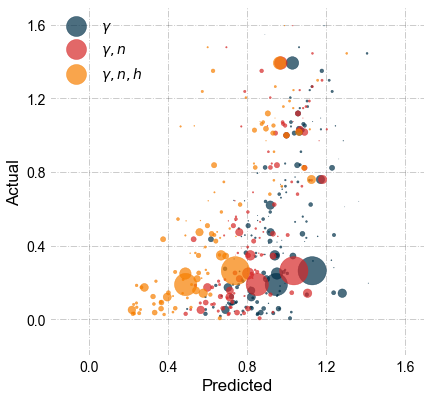

In [30]:
fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(df_fundamentals['rel_GDP_pred_inv'],df_fundamentals['rel_GDP'],
          sizes=df_fundamentals['emp'].values,color=colors[1][0],alpha=.7,label='$\gamma$')
ax.scatter(df_fundamentals['rel_GDP_pred_inv_emp'],df_fundamentals['rel_GDP'],
          sizes=df_fundamentals['emp'].values,color=colors[1][1],alpha=.7,label='$\gamma,n$')
ax.scatter(df_fundamentals['rel_GDP_pred_inv_emp_hc'],df_fundamentals['rel_GDP'],
          sizes=df_fundamentals['emp'].values,color=colors[1][2],alpha=.7,label='$\gamma,n,h$')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ticks = [0,.4,.8,1.2,1.6]
ax.set_xlim(-0.2,1.7)
ax.set_ylim(-0.2,1.7)
ax.set_xticks(ticks)
ax.set_yticks(ticks)


ax.legend(loc='upper left',frameon=False)
plt.savefig('./rel_GDP_pred_inv_emp_hc.svg',bbox_inches='tight')

When we look at all the countries, the model does well as we control more and more variables. However, as shown in our table, the model does not do as well with 4 examples of advanced economies. We could conclude that the Solow model does in well in accounting for the income per worker differences between developed and developing countries. But, it does not do as well for accounting for the income per worker differences between developed countries, like the UK, Italy and Denmark listed in our question. Productivity differences is the main factor accounting the income per differences among  the developed countries.

2. Consider the extended Solow model. Suppose the production function is $Y =  K^\alpha (ehL)^{1-\alpha}.$

a. Derive change in capital per effective worker, $\dot{\tilde{k}}$, as a function of capital per effective worker, $\tilde{k}$, and other exogenous variables in the model.

b. Suppose that investment rate is 20%, $\gamma =.2$, depreciation rate is 5\%, $\delta=.05$, population growth rate is 1\%, $n=.01$, labor-augmenting technological progress rate is 2\%, $g = .02$, human capital is equal to 1, $h=1$,  and capital income share is .33, $\alpha=.33$. Find steady state capital per effective worker, income per effective worker, consumption per effective worker.

c. Suppose at time $t=0$, the economy is at the steady state, and level of labor-augmenting technology is equal to 1, $e(0)=1$. What's the income per worker level at time $t=20$? Remember that if a variable (say M) grows at a constant rate, say m, then the value of M at time $t$ is equal to $\exp(mt)$ times the value of M at time $0$, i.e. $M(t)=M(0)\exp(mt).$

d. Suppose again that at time $t=0$, the economy is at the steady state and level of labor-augmenting technology is equal to 1, $e(0)=1$. Now, suddenly (and unexpectedly) the human capital increases by 10\%, i.e. $h^{new} = 1.1$. Starting from the steady state you found in part b, simulate the model for 100 periods, and calculate capital per effective worker, capital per worker, income per effective worker, and income per worker at each time period.


In [31]:
# First, set our parameter values
alpha = .33
delta = .05
h = 1
n = 0.01
g = 0.02
gamma = .2
# this is one way of defining a function in python
# f is our production function, output per effective workers
f = lambda k,h: k**alpha*h**(1-alpha)
# this is our kdot function
kdot = lambda k,h: gamma*k**alpha*h**(1-alpha)-(delta+n+g)*k

At the steady state:
    $$\tilde{k}^\ast = \left(\frac{\gamma}{n+g+\delta}\right)^{1/(1-\alpha)}h $$

Everytime:
  $$ \tilde{y} = \tilde{k}^\alpha h^{1-\alpha} $$
  $$ \tilde{c} = (1-\gamma)\tilde{y}$$

In [32]:
# calculate the steady state variables
k_tilde_ss = (gamma/(n+delta+g))**(1/(1-alpha))*h
y_tilde_ss = k_tilde_ss**alpha*h**(1-alpha)
c_tilde_ss = y_tilde_ss*(1-alpha)

In [33]:
print('Steady state capital per effective worker = ', np.round(k_tilde_ss,decimals=2))
print('Steady state ouput per effective worker = ', np.round(y_tilde_ss,decimals=2))
print('Steady state consumption per effective worker = ', np.round(c_tilde_ss,decimals=2))

Steady state capital per effective worker =  3.93
Steady state ouput per effective worker =  1.57
Steady state consumption per effective worker =  1.05


Recall the definition of $\tilde{y} \equiv \frac{Y}{eL}$ and  $y\equiv \frac{Y}{L}$. Therefore, $y=e\tilde{y}$. In part c, the economy is at the steady state, $\tilde{y}\ast$, and $e$ is growing at a constant rate. But we know the initial value of $e(0)=1$, the growth rate of $e$, $g=0.02$. Therefore, $e(20)=e(0)\exp(g*20).$ Hence, $y(20)=e(20)*\tilde{y}^\ast$. 

In [34]:
print('Income per worker at t=20 is equal to', np.round(np.exp(g*20)*y_tilde_ss,decimals=2))

Income per worker at t=20 is equal to 2.34


To solve for part d, we first need to simulate $\tilde{k}$ and $\tilde{y}$ over time. We can quite easily calculate $e$ over time using the initial value of $e$, $e(0)$, and the growth rate of $e$, $g=0.02$. Then using $y(t)=\tilde{y(t)}e(t)$ equality, we can generete $y$ sequence over time.

In [35]:
# k_tilde_seq will be sequence of k tilde over time
# since the economy was at the steady state, I initiate k_tilde sequence with 10 values...
# all equal to the steady state value
# you assume this is the value of k_tilde before time t=0 and at time t=0,...
# as there is no change in k_tilde at time t=0. k_tilde will begin increasing at t=1
k_tilde_seq = [k_tilde_ss,]*10

In [36]:
# I also create a sequence of human capital
# h is equal to 1 initially, then it becomes 1.1
h_seq = np.ones(111)
# assume 9th element of the sequence corresponds to time t=0
h_seq[9:] = 1.1

In [37]:
# starting from the 9th element, or time t=0, simulate the model to get k_tilde over time
for t in range(9,110):
    # k_prime is the next periods capital
    # k_prime is equal to current capital plus the change in capital
    k_prime = k_tilde_seq[t]+kdot(k_tilde_seq[t],h_seq[t])
    k_tilde_seq.append(k_prime)

In [38]:
# generate e sequence as given in the formula: e(t) = e(0)*exp(g*t)
e_seq = [np.exp(t*g) for t in range(-9,102)]

In [39]:
# k = k_tilde*e
k_seq = np.array(k_tilde_seq)*np.array(e_seq)

In [40]:
# y_tilde = k_tilde^alpha*h^(1-alpha)
y_tilde_seq = [f(k_tilde_seq[t],h_seq[t]) for t in range(111)]

In [41]:
# y = y_tilde*e
y_seq = np.array(y_tilde_seq)*np.array(e_seq)

In [42]:
# now put all these variables into a table
df2 = pd.DataFrame({'Time':np.arange(-9,102),
                    'h':h_seq,
                    'k tilde':k_tilde_seq,
                   'y tilde':y_tilde_seq,
                   'e':e_seq,
                   'k':k_seq,
                   'y':y_seq})

In [43]:
# here is how our data looks like
df2.head(15)

,Time,h,k tilde,y tilde,e,k,y
0,-9,1.0,3.925910,1.570364,0.835270,3.279195,1.311678
1,-8,1.0,3.925910,1.570364,0.852144,3.345440,1.338176
2,-7,1.0,3.925910,1.570364,0.869358,3.413022,1.365209
3,-6,1.0,3.925910,1.570364,0.886920,3.481970,1.392788
4,-5,1.0,3.925910,1.570364,0.904837,3.552310,1.420924
5,-4,1.0,3.925910,1.570364,0.923116,3.624071,1.449629
6,-3,1.0,3.925910,1.570364,0.941765,3.697283,1.478913
7,-2,1.0,3.925910,1.570364,0.960789,3.771973,1.508789
8,-1,1.0,3.925910,1.570364,0.980199,3.848172,1.539269
9,0,1.1,3.925910,1.673915,1.000000,3.925910,1.673915


In [44]:
df2[df2.Time==60].round(decimals=2)

,Time,h,k tilde,y tilde,e,k,y
69,60,1.1,4.3,1.73,3.32,14.29,5.73


Text(0.5, 1.0, '$\\tilde{k}$')

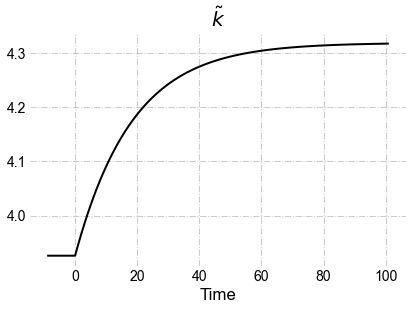

In [45]:
# plot k_tilde over time
fig,ax = plt.subplots()
plt.plot(df2.Time,df2['k tilde'],'k',linewidth=2)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time')
ax.set_title(r'$\tilde{k}$')

Text(0.5, 1.0, '$\\tilde{y}$')

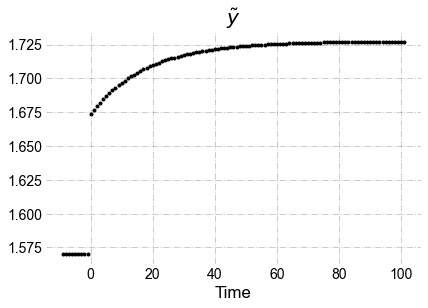

In [46]:
# plot y_tilde over time
fig,ax = plt.subplots()
plt.plot(df2.Time,df2['y tilde'],'k.',linewidth=2)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time')
ax.set_title(r'$\tilde{y}$')

Text(0.5, 1.0, '$k$')

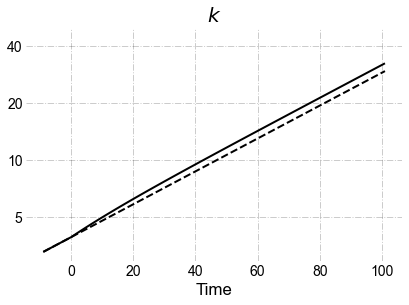

In [47]:
# plot k over time
yticks = [5,10,20,40]
fig,ax = plt.subplots()
plt.plot(df2.Time,df2['k'],'k',linewidth=2)
plt.plot(df2.Time,k_tilde_ss*np.array(e_seq),'k--',linewidth=2)
ax.set_yscale('log')
ax.set_ylim(ymax=50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time')
ax.set_title(r'$k$')

Text(0.5, 1.0, '$y$')

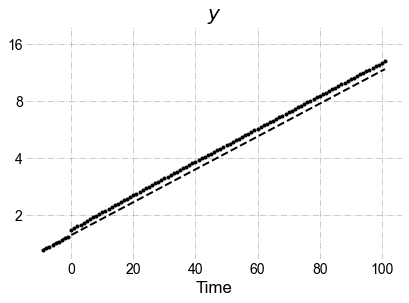

In [48]:
# plot y over time
yticks = [2,4,8,16]
fig,ax = plt.subplots()
plt.plot(df2.Time,df2['y'],'k.',linewidth=2)
plt.plot(df2.Time,y_tilde_ss*np.array(e_seq),'k--',linewidth=2)
ax.set_yscale('log')
ax.set_ylim(ymax=20)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time')
ax.set_title(r'$y$')

Text(0.5, 1.0, '$\\dot{y}/y$')

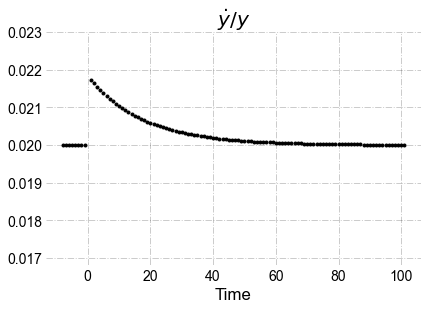

In [49]:
# plot growth rate of y over time
fig,ax = plt.subplots()
plt.plot(df2.Time,np.log(df2['y']).diff(),'k.',linewidth=2)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(ymax= .023)
ax.set_xlabel('Time')
ax.set_title(r'$\dot{y}/y$')